In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
%aimport cca_compare
%aimport irmad

from scipy.stats import multivariate_normal
from collections import defaultdict

import gdal
import gdalio
from sklearn.cross_decomposition import CCA
import scipy as sc
from scipy import stats
from scipy.spatial.distance import cosine
import weightedstats as ws

import os
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression


Populating the interactive namespace from numpy and matplotlib


In [2]:
def variance(x,w=None):
    if w is None:
        w = np.ones(x.shape)
    
    x_mean = (w*x).sum()/w.sum()
    
    return (w*((x-x_mean)**2)).sum()/(w.sum()-1)

def covariance(x,y,w=None):
    if w is None:
        w = np.ones(x.shape)
    
    x_mean = (w*x).sum()/w.sum()
    y_mean = (w*y).sum()/w.sum()
    
    return (w*(x-x_mean)*(y-y.mean())).sum()/(w.sum()-1)

def correlation(x,y,w=None):
    if w is None:
        w = np.ones(x.shape)
        
    return covariance(x,y,w=w)/sqrt(variance(x,w=w))/sqrt(variance(y,w=w))

def median_absolute_deviation(arr,weights):
    median = ws.weighted_median(arr,weights=weights)
    return 1.4826*ws.weighted_median( np.abs(arr-median), weights=weights )

def compare_side_by_side(img1,img2,pmin=None,pmax=None):
    s1 = np.linspace(-1,1,img1.shape[0])[:,np.newaxis] @ np.ones(img1.shape[1])[np.newaxis]
    s2 = np.ones(img1.shape[0])[:,np.newaxis] @ np.linspace(-1,1,img1.shape[1])[np.newaxis]
    disp_weights = 1/(1+np.exp((s1+s2)*50))[:,:,np.newaxis]
    img_total = (img1*disp_weights)+(img2*(1-disp_weights))
    
    if pmin is None or pmax is None:
        pmin = np.percentile(img_total,p,axis=(0,1))
        pmax = np.percentile(img_total,100-p,axis=(0,1))
        
    return normalize(img_total,pmin,pmax)

# Preparation
## Load dataset filenames

In [3]:
# load test dataset

import csv

with open("test_files_aligned.csv",'r') as f:
    reader = csv.reader(f.readlines())
    next(reader) # skip header
    test_pairs = [i for i in reader]
    print(len(test_pairs),'pairs loaded')

59 pairs loaded


## Set sample images

In [4]:
f1, f2 = test_pairs[6]
img1, img2 = gdalio.readAsArray(gdal.Open(f1)), gdalio.readAsArray(gdal.Open(f2))
not_null_mask = (( (img1 == 0).sum(axis=2) == 0 ) & ( (img2 == 0).sum(axis=2) == 0 ))

In [5]:
def normalize(data,pmin,pmax,clamp=True):
    ret = (data - pmin)/(pmax-pmin)
    if clamp:
        ret[ret<0] = 0
        ret[ret>1] = 1
    return ret

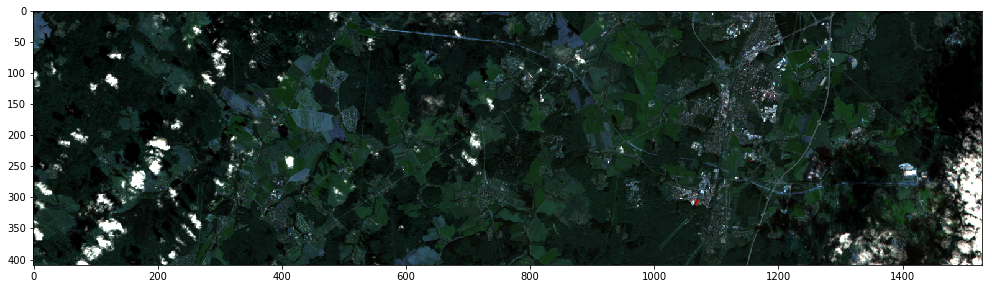

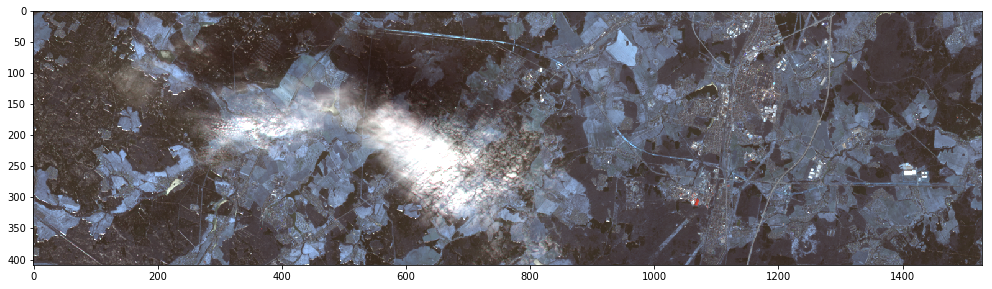

In [6]:


p_min = np.percentile( np.concatenate( (img1[not_null_mask].reshape(-1,img1.shape[-1]),img2[not_null_mask].reshape(-1,img2.shape[-1])),axis=0 ), 1, axis=(0) )
p_max = np.percentile( np.concatenate( (img1[not_null_mask].reshape(-1,img1.shape[-1]),img2[not_null_mask].reshape(-1,img2.shape[-1])),axis=0 ), 99, axis=(0) )

figsize(17,17)
imshow( normalize( img1, p_min, p_max )[:,:,1:4], );
show();
imshow( normalize( img2, p_min, p_max )[:,:,1:4], );

In [7]:
k = img1.shape[2]
cca = new_CCA.CCA(k)

X = img1[not_null_mask].reshape(-1,k)
Y = img2[not_null_mask].reshape(-1,k)
w = np.ones(X.shape[0])
img2_new = img2
iteration_num = 0

b_log = []
a_log = []
cor_log = []

# Iteration

In [8]:
for i in range(20):
    cca.reset()
    cca.push(X,Y,w=w)
    A,B,reg = cca.calc()
    b_log.append(B)
    a_log.append(A)


    u_var  = np.diagonal( cca.a.T @ cca.xx_cov @ cca.a )
    v_var  = np.diagonal( cca.b.T @ cca.yy_cov @ cca.b )
    uv_cov = np.diagonal( cca.a.T @ cca.xy_cov @ cca.b )
    uv_cor = uv_cov/sqrt(u_var)/sqrt(v_var)
    cor_log.append(uv_cor)

    m_var = (u_var + v_var - 2*uv_cov)
    u_mean = np.ravel( cca.a.T @ cca.x_wsum/cca.w_sum )
    v_mean = np.ravel( cca.b.T @ cca.y_wsum/cca.w_sum )
    m_mean = u_mean-v_mean

    U = A.T @ X.T
    V = B.T @ Y.T

    #m_var_got = np.array( [ variance(m,w=w) for m in (U-V)] )

    M = ( ( (U-V).T-m_mean)/np.sqrt(m_var) ).T
    w = ( 1-sc.stats.chi2.cdf( (M**2).sum(axis=0) , k, 0 ) )
    
    # Robust fix
#     m_mean_robust = np.array( [ ws.weighted_median(m[w > 0.5],weights=w[w > 0.5]) for m in M ] )
#     m_std_robust = np.array( [ median_absolute_deviation(m[w > 0.5],weights=w[w > 0.5]) for m in M ] )
#     M = ((M.T - m_mean_robust)/m_std_robust).T
#     w = ( 1-sc.stats.chi2.cdf( (M**2).sum(axis=0) , k, 0 ) )
    
    iteration_num += 1
    print("Success. current iteration: {}".format(iteration_num))
    print("Fall-out: {}".format(1-w.mean()))

Success. current iteration: 1
Fall-out: 0.28264548870338835
Success. current iteration: 2
Fall-out: 0.5531233458340737
Success. current iteration: 3
Fall-out: 0.700424601353657
Success. current iteration: 4
Fall-out: 0.7922914145521621
Success. current iteration: 5
Fall-out: 0.8486756703253637
Success. current iteration: 6
Fall-out: 0.8848265606626432
Success. current iteration: 7
Fall-out: 0.9085978118787961
Success. current iteration: 8
Fall-out: 0.9245110920621363
Success. current iteration: 9
Fall-out: 0.9355480552161385
Success. current iteration: 10
Fall-out: 0.9434022536018228
Success. current iteration: 11
Fall-out: 0.9493142812794405
Success. current iteration: 12
Fall-out: 0.9538806039577402
Success. current iteration: 13
Fall-out: 0.957176238499985
Success. current iteration: 14
Fall-out: 0.9595548026929819
Success. current iteration: 15
Fall-out: 0.9613240029632288
Success. current iteration: 16
Fall-out: 0.9626867996622053
Success. current iteration: 17
Fall-out: 0.9637709

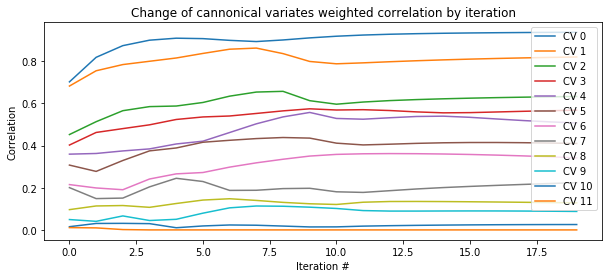

In [10]:
figsize(10,4)
for bn, cor in enumerate( np.array(cor_log).T ):
    plot(cor,label='CV {}'.format(bn))
legend();
title("Change of cannonical variates weighted correlation by iteration")
xlabel("Iteration #")
ylabel("Correlation")
show();

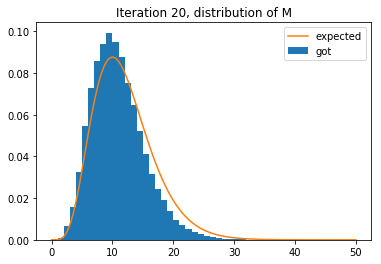

In [11]:
figsize(6,4)
title("Iteration {}, distribution of M".format(iteration_num))
hist( (M**2).sum(axis=0), bins=50,range=[0,50],weights=w,normed=True,label="got");
plot(np.linspace(0,50,100),sc.stats.chi2.pdf(np.linspace(0,50,100),k),label="expected");
legend();

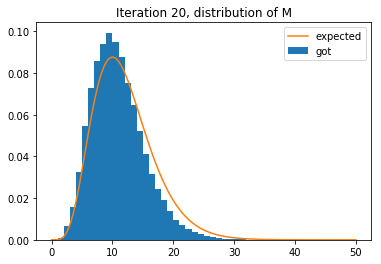

In [12]:
figsize(6,4)
title("Iteration {}, distribution of M".format(iteration_num))
hist( (M**2).sum(axis=0), bins=50,range=[0,50],weights=w,normed=True,label="got");
plot(np.linspace(0,50,100),sc.stats.chi2.pdf(np.linspace(0,50,100),k),label="expected");
legend();

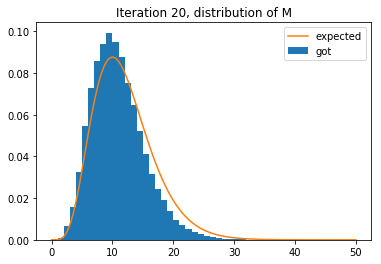

In [13]:
figsize(6,4)
title("Iteration {}, distribution of M".format(iteration_num))
hist( (M**2).sum(axis=0), bins=50,range=[0,50],weights=w,normed=True,label="got");
plot(np.linspace(0,50,100),sc.stats.chi2.pdf(np.linspace(0,50,100),k),label="expected");
legend();

In [14]:
img1.shape[0]*img1.shape[1]

624952

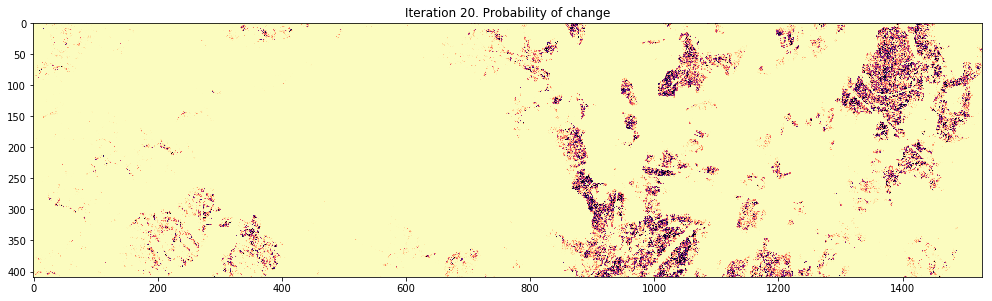

In [15]:
w_disp = np.ones( (img1.shape[0],img1.shape[1]) )
w_disp[not_null_mask] = w

figsize(17,17);
title("Iteration {}. Probability of change".format(iteration_num))
imshow( 1-w_disp, cmap='magma',vmin=0,vmax=1);

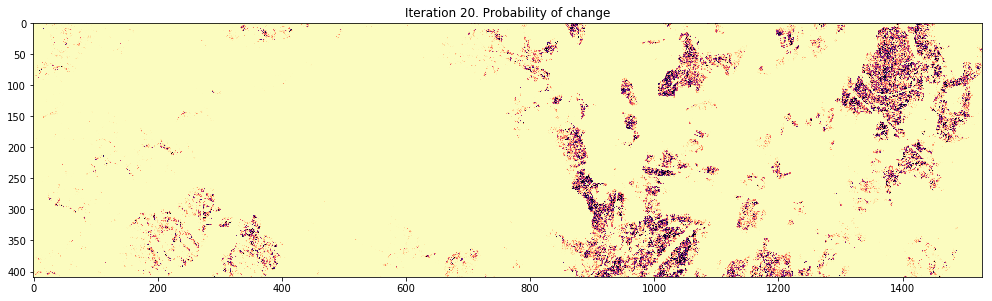

In [16]:
w_disp = np.ones( (img1.shape[0],img1.shape[1]) )
w_disp[not_null_mask] = w

figsize(17,17);
title("Iteration {}. Probability of change".format(iteration_num))
imshow( 1-w_disp, cmap='magma',vmin=0,vmax=1);

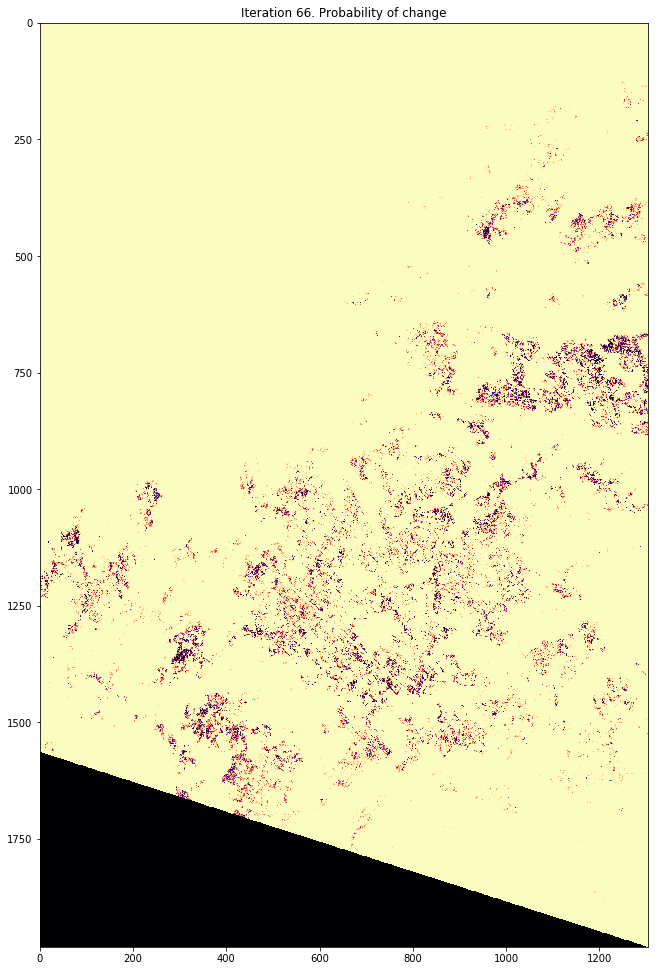

In [23]:
w_disp = np.ones( (img1.shape[0],img1.shape[1]) )
w_disp[not_null_mask] = w

figsize(17,17);
title("Iteration {}. Probability of change".format(iteration_num))
imshow( 1-w_disp, cmap='magma',vmin=0,vmax=1);

# Select pixels with p no change at 95 percent

In [17]:
w_disp = np.zeros( (img1.shape[0],img1.shape[1]) )
w_disp[not_null_mask] = w

x_reg = img1[ w_disp.reshape((img1.shape[0],img1.shape[1]) ) > 0 ]
y_reg = img2[ w_disp.reshape((img1.shape[0],img1.shape[1]) ) > 0 ]
w_reg = w_disp[ w_disp>0 ]
v2 = []
for i in range( x_reg.shape[1] ):
#     try:
#         reg = RANSACRegressor()
#         reg.fit(y_reg[:,i,np.newaxis],x_reg[:,i],w_reg)
#         v2.append( reg.predict( img2.reshape(-1,x_reg.shape[1])[:,i,np.newaxis] ) )
        
#     except ValueError as ex:
#         print("failed RANSAC at {}".format(i))
#         #v2.append(np.ravel(img2[:,:,i]))

    #odr_reg = fit_odr(y_reg[:,i][w_reg>0.97],x_reg[:,i][w_reg>0.97])    
    #v2.append( predict_odr(odr_reg, img2.reshape(-1,x_reg.shape[1])[:,i] ) )
    
    reg = HuberRegressor(fit_intercept=True)
    reg.fit(y_reg[:,i,np.newaxis],x_reg[:,i],w_reg)
    v2.append( reg.predict( img2.reshape(-1,x_reg.shape[1])[:,i,np.newaxis] ) )
        
v2 = np.array(v2).T
img2_new = v2.reshape(img2.shape)

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
from scipy import odr

def fit_odr(x,y):
    def linear_odr(B, x):
        '''Linear function y = m*x + b'''
        # B is a vector of the parameters.
        # x is an array of the current x values.
        # x is in the same format as the x passed to Data or RealData.
        #
        # Return an array in the same format as y passed to Data or RealData.
        return B[0]*x + B[1]

    odr_linear = odr.Model(linear_odr)
    odr_data = odr.Data(x, y)
    
    lin_reg = LinearRegression()
    lin_reg.fit(x[:,np.newaxis],y)

    odr_sess = odr.ODR(odr_data, odr_linear, beta0=[lin_reg.coef_[0], lin_reg.intercept_])
    odr_output = odr_sess.run()
    return odr_output.beta

def predict_odr(beta,x):
    return beta[0]*np.array(x) + beta[1]

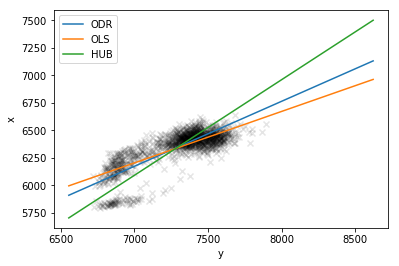

In [20]:

band_index = 3

odr_reg = fit_odr(y_reg[:,band_index][w_reg>0.97],x_reg[:,band_index][w_reg>0.97])

lin_reg = LinearRegression()
lin_reg.fit(y_reg[:,band_index,np.newaxis],x_reg[:,band_index],w_reg)

hub_reg = HuberRegressor()
hub_reg.fit(y_reg[:,band_index,np.newaxis],x_reg[:,band_index],w_reg)

figsize(6,4)
scatter( y_reg[:,band_index][w_reg>0.95], x_reg[:,band_index][w_reg>0.95], c='k', marker='x', alpha=0.1);
ylabel("x");
xlabel("y");
y_pred_space =  np.linspace(y_reg[:,band_index].min(),y_reg[:,band_index].max(),100) 
plot( y_pred_space, predict_odr(odr_reg,y_pred_space),label="ODR");
plot( y_pred_space, lin_reg.predict(y_pred_space[:,np.newaxis]),label="OLS" )
plot( y_pred_space, hub_reg.predict(y_pred_space[:,np.newaxis]),label="HUB" )
legend();

# After irmad

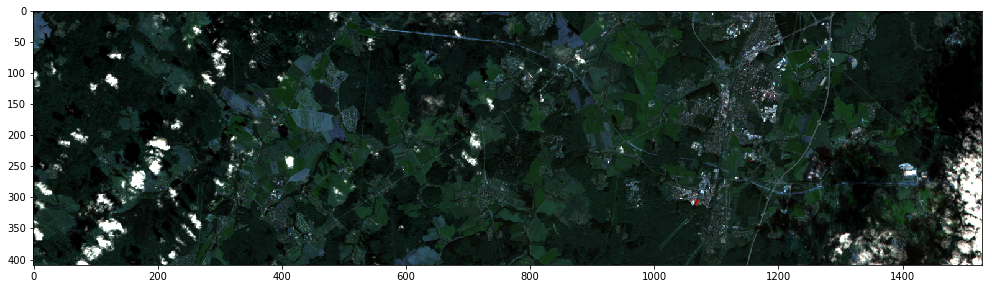

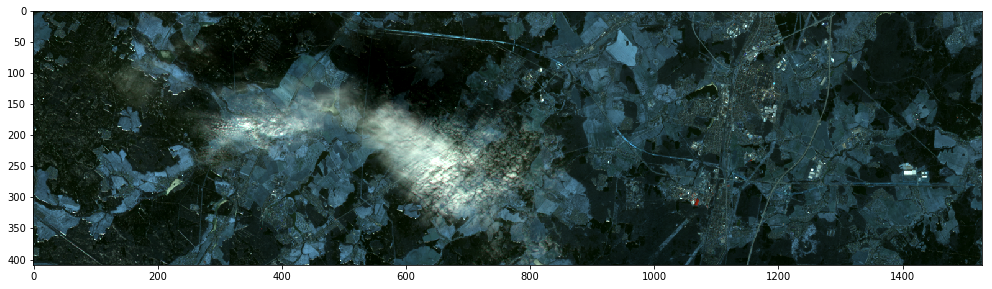

In [21]:
#p_min = np.percentile( np.concatenate( (img1.reshape(-1,img1.shape[-1]),img2_new.reshape(-1,img2_new.shape[-1])),axis=0 ), 1, axis=(0) )
#p_max = np.percentile( np.concatenate( (img1.reshape(-1,img1.shape[-1]),img2_new.reshape(-1,img2_new.shape[-1])),axis=0 ), 99, axis=(0) )
figsize(17,17)
imshow( normalize( img1, p_min, p_max )[:,:,1:4], );
show();
imshow( normalize( img2_new, p_min, p_max )[:,:,1:4], );

# After irmad 2

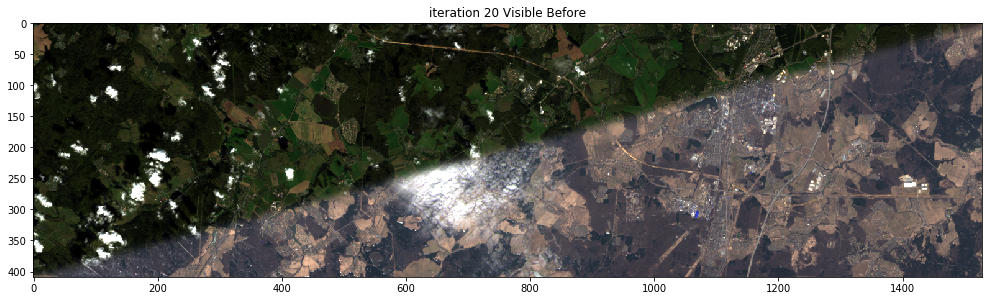

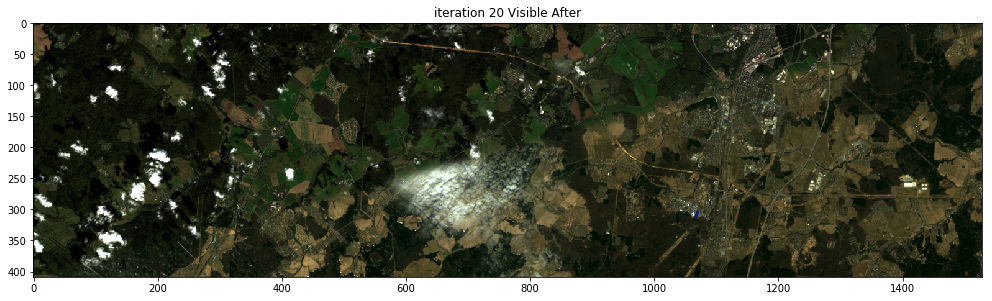

In [26]:
title("iteration {} Visible Before".format(iteration_num) );
imshow( compare_side_by_side(img1,img2, p_min, p_max)[:,:,[3,2,1]] );
show();

title("iteration {} Visible After".format(iteration_num) );
imshow( compare_side_by_side(img1,img2_new, p_min, p_max)[:,:,[3,2,1]] );
show();

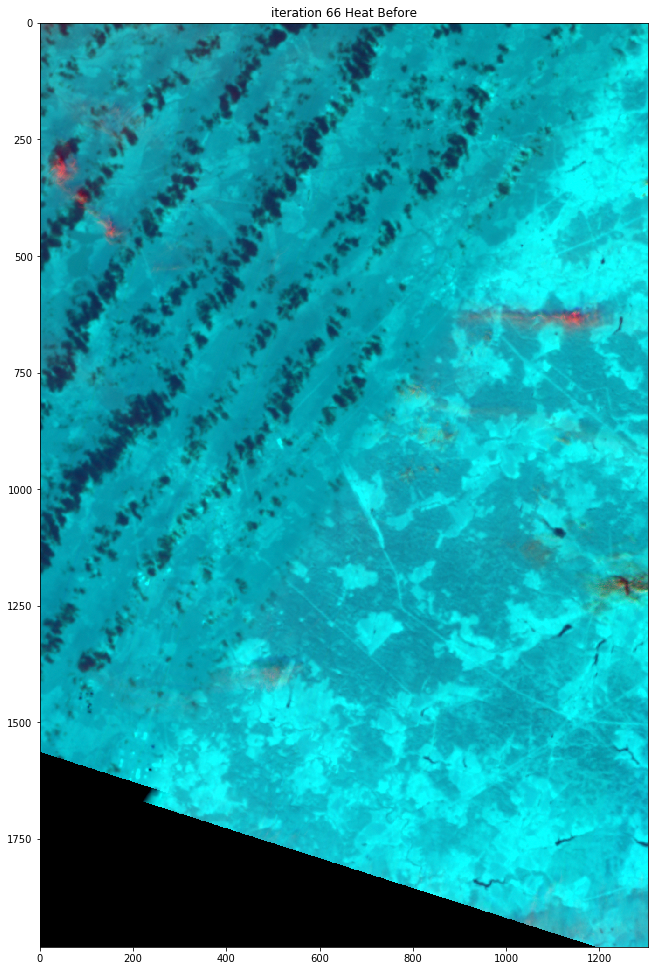

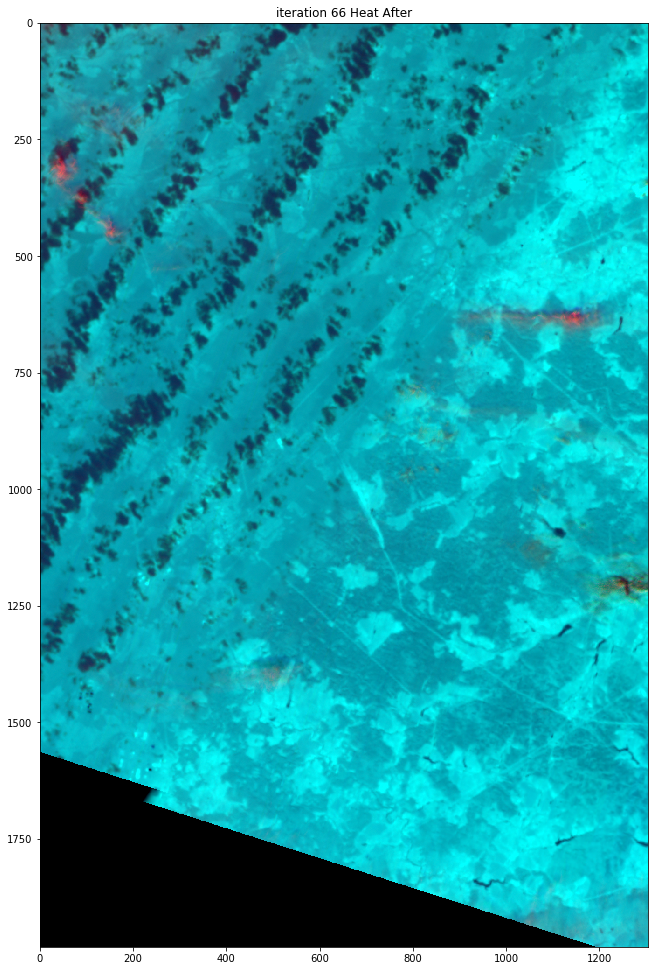

In [30]:
title("iteration {} Heat Before".format(iteration_num));
imshow( compare_side_by_side(img1,img2,p_min,p_max)[:,:,8:11] );
show();

title("iteration {} Heat After".format(iteration_num));
imshow( compare_side_by_side(img1,img2_new,p_min,p_max)[:,:,8:11] );
show();

In [128]:
# calc weights

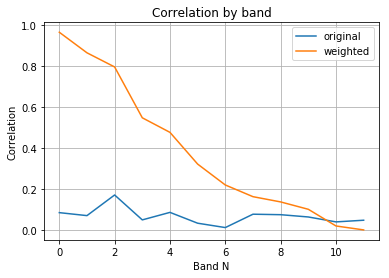

In [35]:
figsize(6,4)
title("Correlation by band")
plot( np.array( [abs(correlation(U[i],V[i])) for i in range(k)] ), label='original');
plot( np.array( [abs(correlation(U[i],V[i],w=w)) for i in range(k)] ), label='weighted');
xlabel("Band N")
ylabel("Correlation");
legend();
grid();
show();

# Save to files

In [22]:
dest_folder = './pics/sample3'

if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
    
#imsave('{}/visible_iter{}.png'.format(dest_folder,iteration_num), compare_side_by_side(img1,img2,p_min,p_max)[:,:,1:4] )
imsave('{}/visible_iter{}.png'.format(dest_folder,iteration_num), compare_side_by_side(img1,img2_new,p_min,p_max)[:,:,1:4] )

#imsave('{}/iter{}_heat_before.png'.format(dest_folder,iteration_num), compare_side_by_side(img1,img2)[:,:,8:11] )
imsave('{}/heat_iter{}.png'.format(dest_folder,iteration_num), compare_side_by_side(img1,img2_new,p_min,p_max)[:,:,8:11] )

w_disp = np.ones( (img1.shape[0],img1.shape[1]) )
w_disp[not_null_mask] = w

cmap = plt.cm.jet
imsave( '{}/change_probability_iter{}.png'.format(dest_folder,iteration_num), cmap( 1-w_disp ) )